# Set-up

## Imports

In [1]:
# Standard
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
from os.path import join

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
plt.rcParams['savefig.dpi'] = 300
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm, trange
import plotly.graph_objects as go
import textwrap

# Sci-kit learn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, f1_score, classification_report, matthews_corrcoef, PrecisionRecallDisplay
import joblib
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# ALE
# from alibi.explainers import ALE, plot_ale

# SHAP
import shap

# GeoPandas (for plotting)
import geopandas as gpd

## Parameters

In [98]:
scope = 'BID'

input_path = f'../data/2_processed/ML_dataset_{scope}.pkl'
model_folder = f'{scope}/model_dumps/classifier'

train_years = [2021]
test_years = [2022]

subsample_frac = None
run_ALE = False

target = 'Result'

features_to_encode = [
    'MargTech',
    'WorkDay',
    'Prov',
    'Tech',
]

other_features = [
    'hour',
    'SC_PC1',
    'SC_PC2',
    'IN_PC1',
    'IN_PC2',
    'CT_PC1',
    'CT_PC2',
    'PurchMGP',
    'SellMGP',
    'SolarAngle',
    'DeclAngle',
    'PVnew',
    'PriceDiff',
    'Qty'
]

features = features_to_encode + other_features

In [99]:
province_codes = {
    'Milano': 'MI',
    'Belluno': 'BL',
    'Bologna': 'BO',
    'Verona': 'VR',
    'Bolzano': 'BZ',
    'Bergamo': 'BG',
    'Cuneo': 'CN',
    'Vicenza': 'VI',
    'Pordenone': 'PN',
    'Lodi': 'LO',
    'Brescia': 'BS',
    'Treviso': 'TV',
    'Venezia': 'VE',
    'Sondrio': 'SO',
    'Verbano-Cusio-Ossola': 'VB',
    'Como': 'CO',
    'Aosta': 'AO',
    'Torino': 'TO',
    'Trento': 'TN',
    'Gorizia': 'GO',
    'Vercelli': 'VC',
    'Novara': 'NO',
    'Pavia': 'PV',
    'Mantova': 'MN',
    'Ravenna': 'RA',
    'Varese': 'VA',
    'Ferrara': 'FE',
    'Udine': 'UD',
    'Savona': 'SV',
    'Piacenza': 'PC',
    'La Spezia': 'SP',
    'Genova': 'GE',
    'Reggio Emilia': 'RE'
}

## Functions

In [100]:
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

def group_categorical_shap(shap_values, feature_names, df_to_explain):
    n_expl = shap_values.shape[0]
    p_encoded = shap_values.shape[1]
    p = len(feature_names)

    group_map = np.zeros(p_encoded)
    for i, feature in enumerate(feature_names):
        for j, encoded_feature in enumerate(shap_values.feature_names):
            if encoded_feature.startswith(feature):
                group_map[j] = i

    group_shap_values = np.zeros((n_expl, p, 2))
    
    for group_id in range(p):
        features_to_group = np.where(group_map == group_id)[0]
        group_shap_values[:, group_id, :] = shap_values.values[:, features_to_group, :].sum(axis=1)

    group_shap_values = shap.Explanation(
        values=group_shap_values,
        base_values=shap_values.base_values,
        data=df_to_explain.loc[:, feature_names],
        feature_names=feature_names
    )
    return group_shap_values

# Main

## Load data

In [101]:
input_df = pd.read_pickle(input_path)
print("{:,}".format(len(input_df)))
input_df.head(3)

2,177,292


,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result,RatioAcc,Qty
2018010118UP_ALTOADDA_1_BID,18,20180101,2018,UP_ALTOADDA_1,BID,2.083112,0.480035,-1.932233,-0.782315,1.912031,...,holiday,Milano,Hydro Run-of-river and poundage,0.095,0.095,26.22,-0.349,False,0.0,22.0
2018010119UP_ALTOADDA_1_BID,19,20180101,2018,UP_ALTOADDA_1,BID,1.249924,0.598779,-1.772487,-0.866850,0.891173,...,holiday,Milano,Hydro Run-of-river and poundage,0.095,0.095,26.22,-0.329,False,0.0,22.0
2018010120UP_ALTOADDA_1_BID,20,20180101,2018,UP_ALTOADDA_1,BID,0.243493,0.768175,-1.758348,-0.872364,-0.334594,...,holiday,Milano,Hydro Run-of-river and poundage,0.095,0.095,26.22,-0.324,False,0.0,22.0


In [102]:
# Subsample
if subsample_frac is not None:
    print(f'Subsampled {100*subsample_frac:.0f}% rows from the input dataset')
    df = input_df.sample(frac=subsample_frac)
else:
    df = input_df.copy()

print('Input dataset is composed of {:,} observations'.format(len(input_df)))
print('{:.1%} bids accepted in the input dataset\n'.format(input_df[target].sum() / len(input_df)))

train_df = df[df.year.isin(train_years)]
print('Training data is composed of {:,} observations and correspond to years {}'.format(len(train_df), ' '.join([str(year) for year in train_years])))
print('{:.1%} bids accepted in the training data\n'.format(train_df[target].sum() / len(train_df)))

test_df = df[df.year.isin(test_years)]
# test_df.dropna(subset=['PriceDiff'], inplace=True) # HOTFIX
# test_df = test_df[~(test_df == np.inf).any(axis=1)] # HOTFIX
print('Test data is composed of {:,} observations and correspond to years {}'.format(len(test_df), ' '.join([str(year) for year in test_years])))
print('{:.1%} bids accepted in the test data'.format(test_df[target].sum() / len(test_df)))

Input dataset is composed of 2,177,292 observations
15.9% bids accepted in the input dataset

Training data is composed of 394,157 observations and correspond to years 2021
19.4% bids accepted in the training data

Test data is composed of 333,090 observations and correspond to years 2022
18.1% bids accepted in the test data


In [103]:
# We take of the fact that some categories could be absent in the training set but present in the test set
categories = [input_df[feature].unique() for feature in features_to_encode]

feature_transformer = make_column_transformer(
    (OneHotEncoder(categories=categories), features_to_encode),
    remainder="passthrough",
    verbose_feature_names_out=False
)

X_train = feature_transformer.fit_transform(train_df[features])
y_train = train_df[target]

X_test = feature_transformer.transform(test_df[features])
y_test = test_df[target]

print('Input features are:')
print(feature_transformer.feature_names_in_)

Input features are:
['MargTech' 'WorkDay' 'Prov' 'Tech' 'hour' 'SC_PC1' 'SC_PC2' 'IN_PC1'
 'IN_PC2' 'CT_PC1' 'CT_PC2' 'PurchMGP' 'SellMGP' 'SolarAngle' 'DeclAngle'
 'PVnew' 'PriceDiff' 'Qty']


## Load model

In [104]:
model_path = '{}/model_dumps/model_trained_{}_{}.joblib'.format(scope, scope, '_'.join([str(year) for year in train_years]))
clf = joblib.load(model_path)
print(f'Model {model_path} loaded\n')

Model BID/model_dumps/model_trained_BID_2021.joblib loaded



In [105]:
clf_pipeline = make_pipeline(feature_transformer, clf)

## SHAP for static model

In [106]:
# Get the encoded dataframe passed as input to the model
X_test_df = pd.DataFrame(X_test.toarray(), columns=feature_transformer.get_feature_names_out(), index=test_df.index)
X_test_df

,MargTech_Ccgt,MargTech_Altro,MargTech_Fer,MargTech_Carbone,MargTech_MC,MargTech_I.Fluente,MargTech_Estero,MargTech_I.Pompaggio,MargTech_I.Modulazione,MargTech_Oliocarbone,...,IN_PC2,CT_PC1,CT_PC2,PurchMGP,SellMGP,SolarAngle,DeclAngle,PVnew,PriceDiff,Qty
202201019UP_ALTOADDA_1_BID,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.400913,-1.419636,2.134212,11821.441,7560.569,-58.226106,-23.011637,0.009,-1.000,2.000
2022010110UP_ALTOADDA_1_BID,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.725429,-1.335997,2.190624,12571.768,7994.499,-43.226106,-23.011637,0.009,-1.000,2.000
2022010118UP_ALTOADDA_1_BID,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.046641,-1.448027,2.029188,14194.819,10621.441,76.773894,-23.011637,0.113,-0.410,25.000
2022010119UP_ALTOADDA_1_BID,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.089815,-1.441812,2.029095,14764.205,11054.919,91.773894,-23.011637,0.121,-0.415,27.000
2022010120UP_ALTOADDA_1_BID,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.145514,-1.422603,1.976084,14932.035,11242.601,106.773894,-23.011637,0.121,-0.433,27.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022123117UP_VOGHERA_1_BID,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.875068,-2.527147,1.535322,13549.450,11939.811,61.887169,-23.085911,0.540,-0.350,4.491
2022123118UP_VOGHERA_1_BID,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.607693,-2.561474,1.487904,14776.994,14144.749,76.887169,-23.085911,1.000,-0.420,186.000
2022123119UP_VOGHERA_1_BID,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.548271,-2.484197,1.335766,15015.332,14713.353,91.887169,-23.085911,1.000,-0.414,187.000
2022123120UP_VOGHERA_1_BID,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.630366,-2.484197,1.335766,14903.585,14500.485,106.887169,-23.085911,1.000,-0.405,187.000


In [107]:
# Take a sample to explain
n_samples = 10000
X_test_sample_df = X_test_df.sample(n_samples, random_state=42)

In [108]:
explainer = shap.TreeExplainer(clf, feature_perturbation='tree_path_dependent', model_output='raw')
shap_values = explainer(X_test_sample_df, approximate=True)

### SHAP feature importance

Group shap values for categorical variables

In [109]:
group_shap_values = group_categorical_shap(shap_values, features, test_df.loc[X_test_sample_df.index, features])

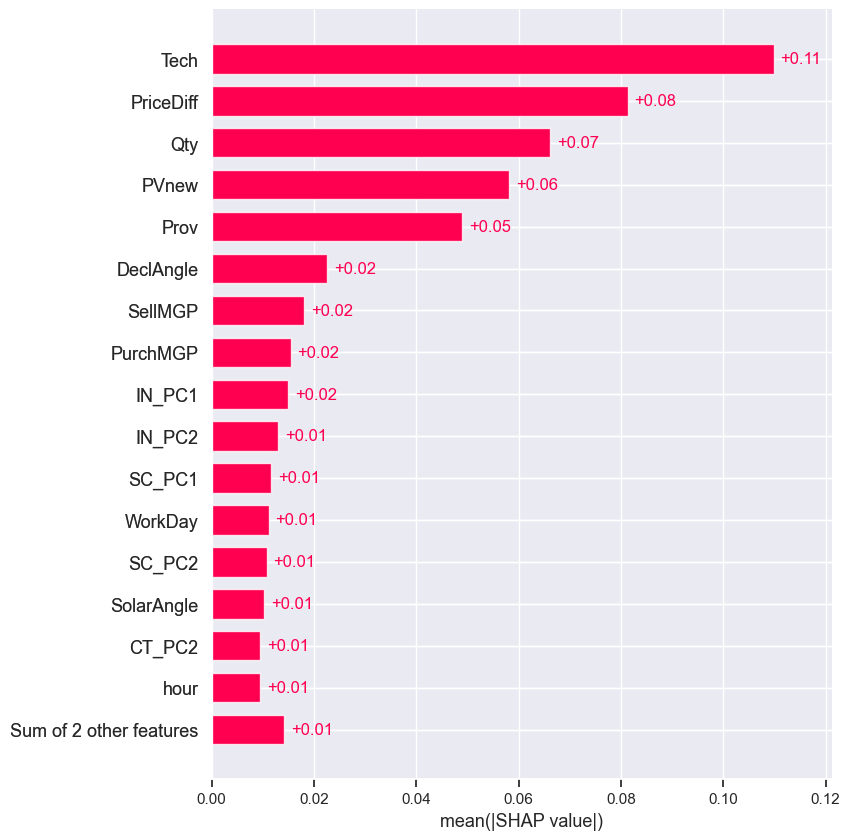

In [110]:
shap.plots.bar(group_shap_values[:, :, 1], max_display=17)

### SHAP dependence plot with numerical variables

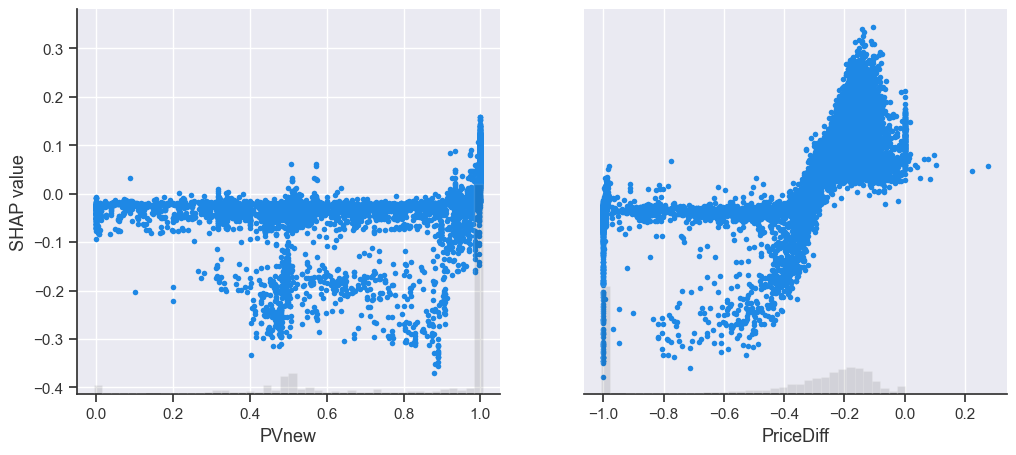

In [111]:
shap.plots.scatter(shap_values[:, ['PVnew', 'PriceDiff'], 1], show=True)

In [112]:
test_df.columns

Index(['hour', 'date', 'year', 'unit', 'scope', 'SC_PC1', 'SC_PC2', 'IN_PC1',
       'IN_PC2', 'CT_PC1', 'CT_PC2', 'PurchMGP', 'SellMGP', 'MargTech',
       'MGPprice', 'GNprice', 'SolarAngle', 'DeclAngle', 'WorkDay', 'Prov',
       'Tech', 'PVold', 'PVnew', 'Price', 'PriceDiff', 'Result', 'RatioAcc',
       'Qty'],
      dtype='object')

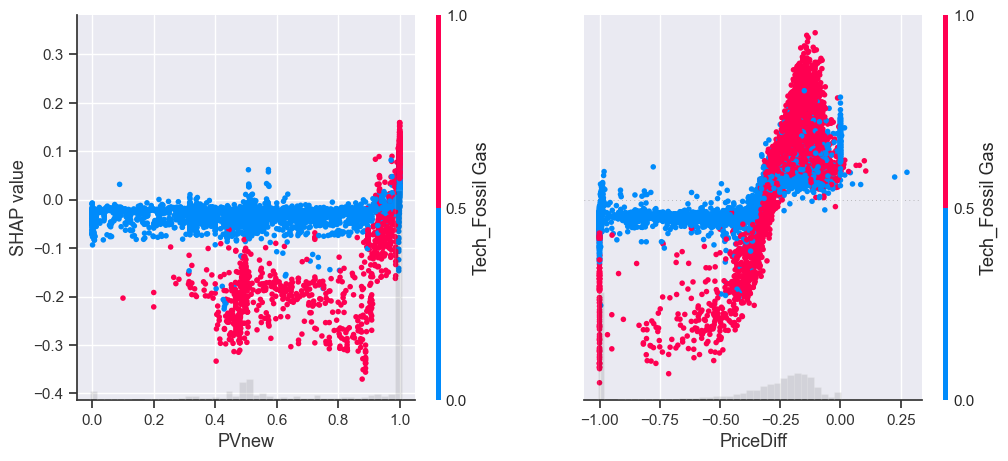

In [113]:
shap.plots.scatter(shap_values[:, ['PVnew', 'PriceDiff'], 1], color=shap_values[:, :, 1], show=True)

In [114]:
tech_shap_df = pd.DataFrame(index=X_test_sample_df.index)
tech_shap_df['Tech'] = test_df.loc[X_test_sample_df.index, "Tech"]
tech_shap_df['Shapley Value'] = group_shap_values[:, "Tech", 1].values
tech_shap_df

,Tech,Shapley Value
2022021619UP_EDOLO_1_BID,Hydro Pumped Storage,-0.086196
2022061910UP_TAVAZZANO_5_BID,Fossil Gas,0.153967
2022040119UP_PIACENZA_4_BID,Fossil Gas,0.151711
202207033UP_PRACOMUNE_1_BID,Hydro Pumped Storage,-0.085407
202209308UP_LIRO_1_BID,Hydro Water Reservoir,-0.072501
...,...,...
202206201UP_RONCOVALG_1_BID,Hydro Pumped Storage,-0.099603
2022050617UP_BRUNICO_M_1_BID,Hydro Water Reservoir,-0.093002
202212103UP_LEVANTE_3_BID,Fossil Gas,0.164827
202209216UP_MONFALCO_1_BID,Fossil Hard coal,-0.063983


### SHAP dependence plot with categorical variables

/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_12252/3988976868.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0)


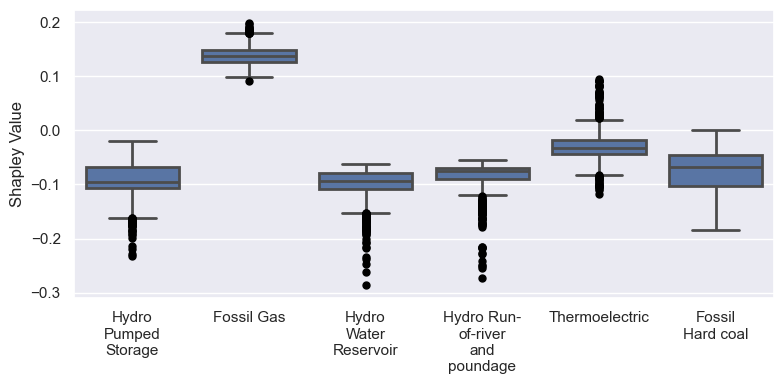

In [115]:
# Define custom properties for fliers
flierprops = {
    'marker': 'o',         # Circle marker
    'markerfacecolor': 'black',  # Red fill
    'markeredgecolor': 'black', # Black edge
    'markersize': 5,       # Adjust size
    'linestyle': 'none'    # No line connecting to fliers
}

plt.figure(figsize=(8, 4))
ax = sns.boxplot(
    data=tech_shap_df,
    x='Tech',
    y='Shapley Value',
    # hue='daytype',
    # hue_order=daytype_order,
    # palette='inferno',
    linewidth=2,  # Set the thickness of the box frames
    flierprops=flierprops
)

ax.set_xlabel(None)
# ax.set_ylabel('Sha', fontsize=fontsize)
# ax.tick_params(axis='both', which='major')
# ax.legend(title=None, loc='upper center', ncols=4)

wrap_labels(ax, 10)
plt.tight_layout()
# plt.savefig(f'../plots/{scope}/explainer/shap_{scope}_test_tech.png')

In [116]:
prov_shap_df = pd.DataFrame(index=X_test_sample_df.index)
prov_shap_df['Prov'] = test_df.loc[X_test_sample_df.index, "Prov"]
prov_shap_df['Shapley Value'] = group_shap_values[:, "Prov", 1].values
prov_shap_df

,Prov,Shapley Value
2022021619UP_EDOLO_1_BID,Brescia,-0.039880
2022061910UP_TAVAZZANO_5_BID,Lodi,0.044722
2022040119UP_PIACENZA_4_BID,Piacenza,-0.029742
202207033UP_PRACOMUNE_1_BID,Bolzano,-0.020745
202209308UP_LIRO_1_BID,Sondrio,-0.024813
...,...,...
202206201UP_RONCOVALG_1_BID,Varese,0.037512
2022050617UP_BRUNICO_M_1_BID,Bolzano,-0.028757
202212103UP_LEVANTE_3_BID,Venezia,0.039416
202209216UP_MONFALCO_1_BID,Gorizia,-0.033928


/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_12252/91271491.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(prov_xtick_names)


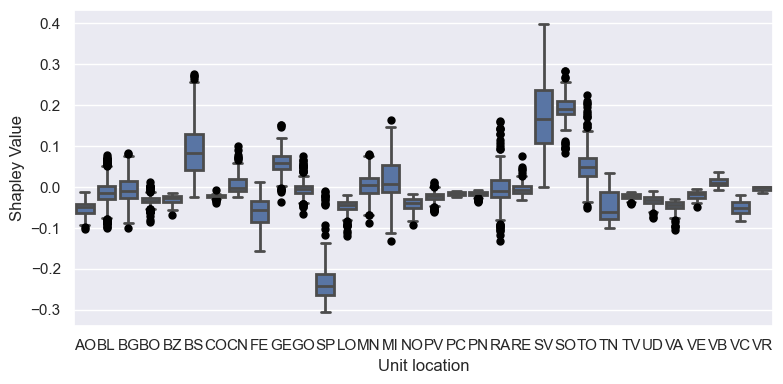

In [117]:
# Define custom properties for fliers
flierprops = {
    'marker': 'o',         # Circle marker
    'markerfacecolor': 'black',  # Red fill
    'markeredgecolor': 'black', # Black edge
    'markersize': 5,       # Adjust size
    'linestyle': 'none'    # No line connecting to fliers
}

plt.figure(figsize=(8, 4))
ax = sns.boxplot(
    data=prov_shap_df,
    x='Prov',
    y='Shapley Value',
    # hue='daytype',
    # hue_order=daytype_order,
    # palette='inferno',
    linewidth=2,  # Set the thickness of the box frames
    flierprops=flierprops
)

ax.set_xlabel('Unit location')
prov_xtick_names = [province_codes[prov] for prov in sorted(province_codes.keys())]
ax.set_xticklabels(prov_xtick_names)
# ax.set_ylabel('Sha', fontsize=fontsize)
# ax.tick_params(axis='both', which='major')
# ax.legend(title=None, loc='upper center', ncols=4)

plt.tight_layout()
# plt.savefig(f'../plots/{scope}/explainer/shap_{scope}_test_prov.png')

## Compute SHAP values for all observations

In [118]:
years = [2019, 2020, 2021, 2022]
subsample = None
random_state = 42

df = input_df[input_df.year.isin(years)]
df['timestamp'] = pd.to_datetime(df['date'].astype(str) + df['hour'].apply(lambda x: "{:02d}".format(x-1)), format='%Y%m%d%H')
df['month'] = df['timestamp'].dt.to_period('M')

In [24]:
months = df.month.unique()
shap_df_list = []

for month in tqdm(months):
    df_to_explain = df[df.month == month]
    X_to_explain = pd.DataFrame(feature_transformer.transform(df_to_explain.loc[:, features]).toarray(), columns=feature_transformer.get_feature_names_out(), index=df_to_explain.index)
    if subsample:
        X_to_explain = X_to_explain.sample(subsample, random_state=random_state)

    model = joblib.load(join(model_folder, '{}.joblib'.format(month.strftime('%Y%m'))))
    
    explainer = shap.TreeExplainer(
        model,
        feature_perturbation='tree_path_dependent',
        model_output='raw'
    )

    shap_values = explainer(X_to_explain, approximate=True)
    group_shap_values = group_categorical_shap(shap_values, features, df.loc[X_to_explain.index, features])

    shap_df = pd.DataFrame(group_shap_values.values[..., 1], columns=features, index=X_to_explain.index)

    shap_df_list.append(shap_df)

shap_df = pd.concat(shap_df_list)
shap_df

  0%|          | 0/48 [00:00<?, ?it/s]

,MargTech,WorkDay,Prov,Tech,hour,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,CT_PC2,PurchMGP,SellMGP,SolarAngle,DeclAngle,PVnew,PriceDiff,Qty
2019010110UP_ALTOADDA_1_BID,-0.001944,0.001213,-0.020375,-0.041775,0.002937,-0.000780,-0.003693,0.007684,0.001265,-0.000015,0.005649,0.005359,-0.001150,0.001235,-0.004931,-0.044801,0.013513,-0.028554
2019010111UP_ALTOADDA_1_BID,0.001500,0.001359,-0.024791,-0.041656,0.003033,-0.000478,0.001487,0.004572,0.007477,0.000868,0.007185,0.010956,-0.001436,0.002684,-0.004981,-0.044837,0.008251,-0.030356
2019010113UP_ALTOADDA_1_BID,-0.000672,0.002199,-0.018591,-0.044268,0.000303,-0.001593,-0.001324,0.000455,0.004114,0.000702,0.003428,0.007750,-0.000718,0.000199,-0.001668,-0.038527,0.013270,-0.034219
2019010114UP_ALTOADDA_1_BID,-0.000140,0.002052,-0.018860,-0.043243,0.001074,0.002493,-0.001669,0.000574,0.007181,-0.004629,0.009431,0.007447,-0.000872,-0.002300,-0.000091,-0.040776,0.017522,-0.034357
2019010116UP_ALTOADDA_1_BID,0.000126,0.001460,-0.020910,-0.040736,0.004161,-0.001067,-0.009878,0.004948,0.016203,-0.000169,-0.002439,0.005003,0.001335,-0.000815,-0.000279,-0.041416,0.007885,-0.032576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022123117UP_VOGHERA_1_BID,0.011512,0.007020,0.103155,0.088712,0.001055,-0.014324,0.030281,0.015390,-0.007908,0.000764,0.012383,0.007266,0.013454,0.004675,-0.014623,-0.205379,-0.046291,-0.084577
2022123118UP_VOGHERA_1_BID,0.009730,0.044486,0.178504,0.089015,0.008805,0.006705,0.063234,0.050713,-0.000647,-0.069093,-0.003923,0.014532,-0.017216,0.028500,-0.079830,0.053330,-0.198096,0.083814
2022123119UP_VOGHERA_1_BID,0.011895,0.046705,0.185340,0.089469,0.009382,0.029598,0.063502,0.055655,-0.000356,-0.031003,-0.001496,0.027113,-0.027413,0.014229,-0.057508,0.053770,-0.182905,0.086584
2022123120UP_VOGHERA_1_BID,0.011852,0.046657,0.178099,0.089361,0.002290,0.034725,0.057781,0.054487,-0.018869,-0.037061,-0.000436,0.021630,-0.019311,0.007788,-0.067571,0.054390,-0.188832,0.085583


In [25]:
shap_df.to_pickle(join(scope, 'shap_values', f'shap_values_{scope}.pkl' ))

In [119]:
shap_df = pd.read_pickle(join(scope, 'shap_values', f'shap_values_{scope}.pkl' ))

In [120]:
shap_df.rename({'PVnew': 'BP'}, axis=1, inplace=True)

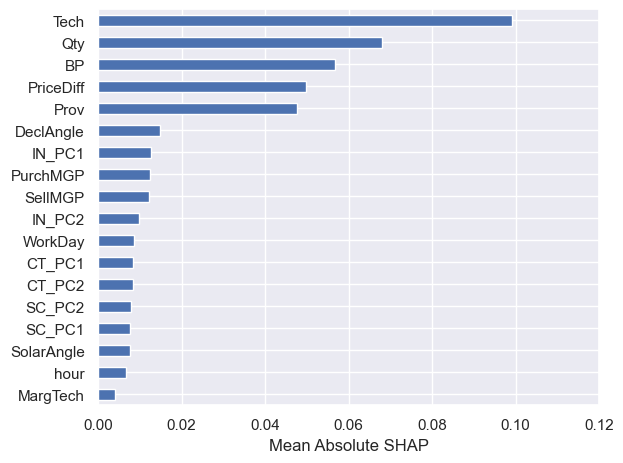

In [121]:
year = ''

if year:
    shap_df[df.year == year].abs().mean().sort_values(ascending=True).plot(kind='barh')
else:
    shap_df.abs().mean().sort_values(ascending=True).plot(kind='barh')

plt.xlabel('Mean Absolute SHAP')
if scope == 'BID':
    plt.xlim((0, 0.12))
else:
    plt.xlim((0, 0.025))
plt.tight_layout()
plt.savefig(f'../plots/{scope}/explainer/shap_{scope}_feature_imp_static{year}.png', dpi=300)

In [122]:
features = [feature if feature != 'PVnew' else 'BP' for feature in features]

In [123]:
features_ordering = shap_df.abs().mean().sort_values(ascending=False).index
monthly_fi = shap_df.abs().groupby(df.month).mean()
features_to_plot = ['Tech', 'BP', 'Qty', 'PriceDiff', 'Prov']
monthly_fi_plot = monthly_fi[features_to_plot]
monthly_fi_plot['Other features'] = monthly_fi[[feature for feature in features if feature not in features_to_plot]].sum(axis=1)
monthly_fi_plot

,Tech,BP,Qty,PriceDiff,Prov,Other features
month,,,,,,
2019-01,0.070897,0.063497,0.064978,0.038337,0.039462,0.101591
2019-02,0.065415,0.062630,0.058482,0.037433,0.041341,0.100723
2019-03,0.069274,0.064422,0.061612,0.036877,0.042790,0.114671
2019-04,0.067554,0.060774,0.057467,0.035114,0.035056,0.109605
2019-05,0.065028,0.051205,0.050512,0.035124,0.037972,0.102984
2019-06,0.061308,0.046328,0.046869,0.043175,0.037545,0.100665
2019-07,0.068020,0.052315,0.050783,0.035253,0.042603,0.089070
2019-08,0.071748,0.059378,0.061170,0.042389,0.040203,0.112924
2019-09,0.082884,0.058321,0.059872,0.044592,0.047536,0.108325


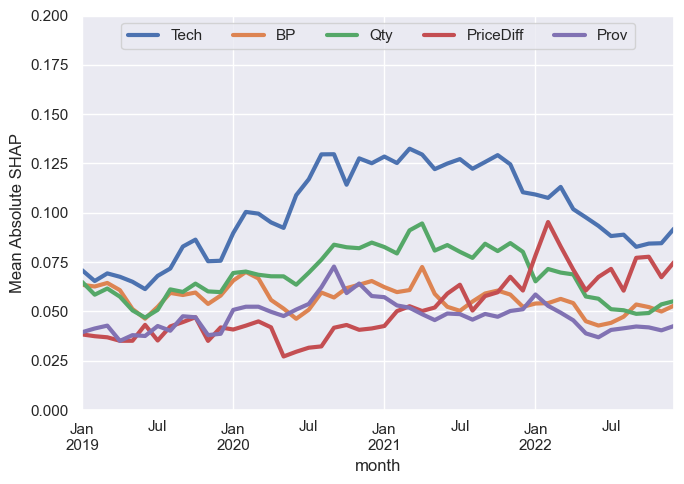

In [124]:
# Your plot
ylim = {
    'OFF': (0, 0.05),
    'BID': (0, 0.2)
}
ax = monthly_fi[features_to_plot].plot(ylim=ylim[scope], linewidth=3, figsize=(7,5))

# Customize the legend
# Move legend to the right
ax.legend(loc='upper center',
        #   bbox_to_anchor=(1.05, 0.5),
        ncol=5,
        # frameon=False
        )

plt.ylabel("Mean Absolute SHAP")
plt.tight_layout()
plt.savefig(f'../plots/{scope}/explainer/shap_{scope}_feature_imp.png', dpi=300)

In [125]:
shap_with_data = pd.concat([shap_df.add_prefix('shap_'), df.rename({'PVnew': 'BP'}, axis=1)], axis=1)

In [126]:
shap_with_data['Tech_Gas'] = shap_with_data.Tech.apply(lambda s: 'Fossil Gas' if s == 'Fossil Gas' else 'Other')

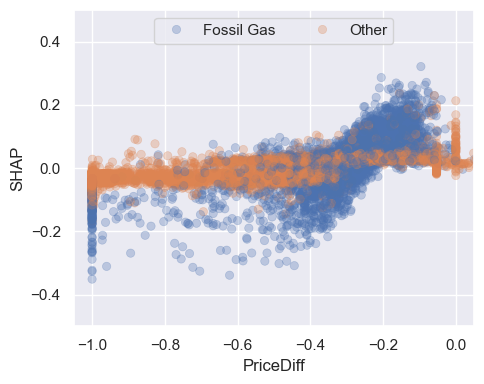

In [127]:
year = ''

fig, ax = plt.subplots(figsize=(5, 4))

if year:
        sns.scatterplot(
                data=shap_with_data[shap_with_data.year == year].sample(10000, random_state=42),
                # data=shap_with_data.sample(10000, random_state=42),
                x='PriceDiff', y='shap_PriceDiff', hue='Tech_Gas', edgecolor=None, alpha=0.3, hue_order=['Fossil Gas', 'Other']
        )
else:
        sns.scatterplot(
                data=shap_with_data.sample(10000, random_state=42),
                # data=shap_with_data.sample(10000, random_state=42),
                x='PriceDiff', y='shap_PriceDiff', hue='Tech_Gas', edgecolor=None, alpha=0.3, hue_order=['Fossil Gas', 'Other']
        )

if scope == 'BID':
        plt.xlim((-1.05, 0.05))
        plt.ylim((-0.5, 0.5))
else:
        plt.xlim((-0.25, 1.05))
#         plt.ylim((-0.5, 0.5))

plt.legend(
        loc='upper center',
        ncol=2,
        # frameon=False
)
plt.ylabel('SHAP')
plt.tight_layout()
plt.savefig(f'../plots/{scope}/explainer/shap_{scope}_dependence_PriceDiff{year}.png', dpi=300)

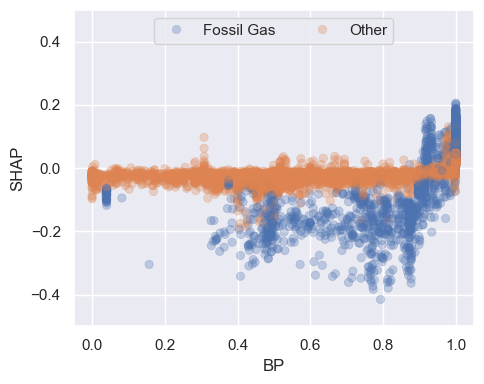

In [128]:
year = ''

fig, ax = plt.subplots(figsize=(5, 4))
if year:
        sns.scatterplot(
                data=shap_with_data[shap_with_data.year == year].sample(10000, random_state=42),
                # data=shap_with_data.sample(10000, random_state=42),
                x='BP', y='shap_BP', hue='Tech_Gas', edgecolor=None, alpha=0.3, hue_order=['Fossil Gas', 'Other']
        )
else:
        sns.scatterplot(
                data=shap_with_data.sample(10000, random_state=42),
                # data=shap_with_data.sample(10000, random_state=42),
                x='BP', y='shap_BP', hue='Tech_Gas', edgecolor=None, alpha=0.3, hue_order=['Fossil Gas', 'Other']
        )
if scope == 'BID':
        # plt.xlim((0.8, 1))
        plt.ylim((-0.5, 0.5))
else:
        # plt.xlim((-1.05, 0.05))
        plt.ylim((-0.2, 0.3))

plt.legend(
        loc='upper center',
        ncol=2,
        # frameon=False
)
plt.ylabel('SHAP')
plt.tight_layout()
plt.savefig(f'../plots/{scope}/explainer/shap_{scope}_dependence_BP{year}.png', dpi=300)

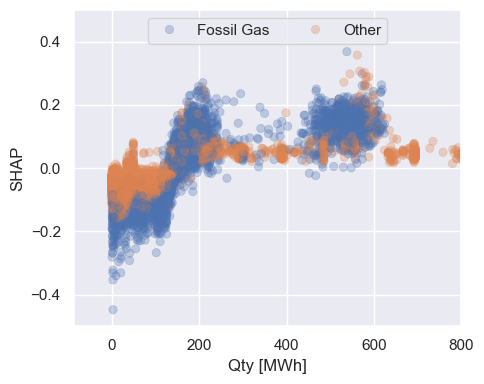

In [129]:
year = ''

fig, ax = plt.subplots(figsize=(5, 4))
if year:
        sns.scatterplot(
                data=shap_with_data[shap_with_data.year == year].sample(10000, random_state=42),
                # data=shap_with_data.sample(10000, random_state=42),
                x='Qty', y='shap_Qty', hue='Tech_Gas', edgecolor=None, alpha=0.3, hue_order=['Fossil Gas', 'Other']
        )
else:
        sns.scatterplot(
                data=shap_with_data.sample(10000, random_state=42),
                # data=shap_with_data.sample(10000, random_state=42),
                x='Qty', y='shap_Qty', hue='Tech_Gas', edgecolor=None, alpha=0.3, hue_order=['Fossil Gas', 'Other']
        )
if scope == 'BID':
        # plt.xlim((0.8, 1))
        plt.ylim((-0.5, 0.5))
        plt.xlim(right=800)
else:
        plt.xlim(right=1050)
        plt.ylim((-0.2, 0.3))

plt.legend(
        loc='upper center',
        ncol=2,
        # frameon=False
)
plt.ylabel('SHAP')
plt.xlabel('Qty [MWh]')
plt.tight_layout()
plt.savefig(f'../plots/{scope}/explainer/shap_{scope}_dependence_Qty{year}.png', dpi=300)

In [130]:
tech_order = ['Hydro Run-of-river and poundage', 'Hydro Water Reservoir', 'Hydro Pumped Storage', 'Fossil Gas', 'Thermoelectric', 'Fossil Hard coal']

/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_12252/3988976868.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0)


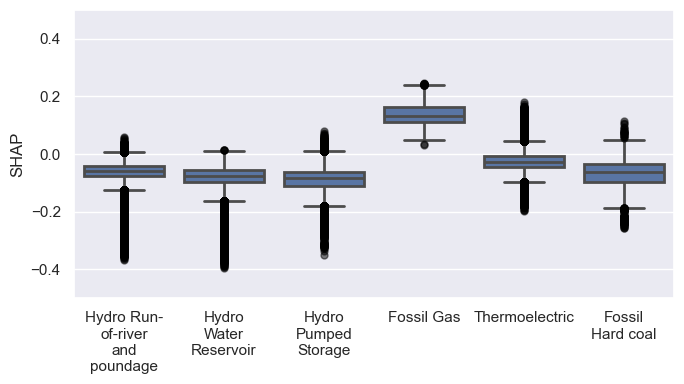

In [131]:
year = ''

# Define custom properties for fliers
flierprops = {
    'marker': 'o',         # Circle marker
    'markerfacecolor': 'black',  # Red fill
    'markeredgecolor': 'black', # Black edge
    'markersize': 5,       # Adjust size
    'linestyle': 'none',    # No line connecting to fliers
    'alpha': 0.5
}

plt.figure(figsize=(7, 4))

if year:
    plot_df = shap_with_data[shap_with_data.year == year]
else:
    plot_df = shap_with_data.copy()

ax = sns.boxplot(
    data=plot_df,
    x='Tech',
    y='shap_Tech',
    order=tech_order,
    # hue='daytype',
    # hue_order=tech_order,
    # palette='inferno',
    linewidth=2,  # Set the thickness of the box frames
    flierprops=flierprops
)

ax.set_xlabel(None)
# ax.set_ylabel('Sha', fontsize=fontsize)
# ax.tick_params(axis='both', which='major')
# ax.legend(title=None, loc='upper center', ncols=4)

wrap_labels(ax, 10)
plt.ylabel('SHAP')
if scope == 'BID':
    plt.ylim((-0.5, 0.5))
else:
    plt.ylim((-0.2, 0.2))
plt.tight_layout()
plt.savefig(f'../plots/{scope}/explainer/shap_{scope}_tech{year}.png', dpi=300)

In [132]:
shap_prov = shap_with_data.groupby('Prov')['shap_Prov'].mean().rename(province_codes)
gdf = gpd.read_file('../data/georef-italy-provincia')
gdf = gdf.merge(shap_prov, left_on='prov_sigla', right_index=True, how='left')
gdf['shap_Prov'] = gdf['shap_Prov'].fillna(0)
gdf = gdf[gdf.rip_name.isin(['Nord-Ovest', 'Nord-Est'])]
gdf.head()

,year,rip_code,rip_name,reg_code,reg_name,prov_code,prov_name,prov_name_u,prov_name_l,prov_area_c,prov_type,prov_sigla,geometry,shap_Prov
1,2022,1,Nord-Ovest,3,Lombardia,18,Pavia,PAVIA,pavia,ITA,Provincia,PV,"MULTIPOLYGON (((8.81427 45.01739, 8.81295 45.0...",0.118965
3,2022,2,Nord-Est,4,Trentino-Alto Adige,21,Bolzano,BOLZANO,bolzano,ITA,Provincia autonoma,BZ,"POLYGON ((12.47759 46.67982, 12.47518 46.67888...",-0.033683
4,2022,2,Nord-Est,5,Veneto,227,Venezia,VENEZIA,venezia,ITA,Citta metropolitana,VE,"POLYGON ((12.66165 45.79243, 12.6632 45.79217,...",0.013995
5,2022,1,Nord-Ovest,7,Liguria,11,La Spezia,LA SPEZIA,la spezia,ITA,Provincia,SP,"MULTIPOLYGON (((9.85137 44.02382, 9.85122 44.0...",0.009621
8,2022,1,Nord-Ovest,3,Lombardia,14,Sondrio,SONDRIO,sondrio,ITA,Provincia,SO,"POLYGON ((9.5269 46.01151, 9.52734 46.0126, 9....",-0.022943


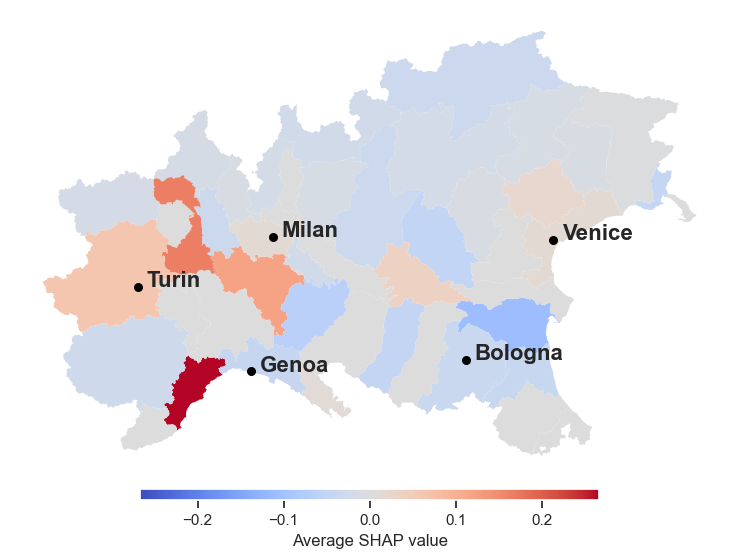

In [133]:
# Example: city coordinates (latitude, longitude)
cities = {
    "Milan": (45.4642, 9.1900),
    # "Rome": (41.9028, 12.4964),
    # "Naples": (40.8518, 14.2681),
    "Turin": (45.0703, 7.6869),
    "Venice": (45.4408, 12.3155),
    # "Florence": (43.7696, 11.2558),
    "Genoa": (44.4056, 8.9463),
    "Bologna": (44.4949, 11.3426)
}

# Create a DataFrame
city_df = pd.DataFrame({
    "city": list(cities.keys()),
    "lat": [coord[0] for coord in cities.values()],
    "lon": [coord[1] for coord in cities.values()]
})

# Convert to GeoDataFrame
city_gdf = gpd.GeoDataFrame(city_df, geometry=gpd.points_from_xy(city_df.lon, city_df.lat), crs="EPSG:4326")

# Assuming `merged` is your choropleth-ready GeoDataFrame
fig, ax = plt.subplots(figsize=(8, 6))
gdf.plot(column='shap_Prov', cmap='coolwarm', legend=True, ax=ax, vmin=-max(abs(gdf["shap_Prov"])), vmax=max(abs(gdf["shap_Prov"])),
         edgecolor='none',
    legend_kwds={
        'orientation': 'horizontal',
        'shrink': 0.6,         # Shrinks the height of the color bar
        'aspect': 40,          # Makes it narrower
        'pad': 0.02,           # Space between map and color bar
        'label': "Average SHAP value"  # Optional label
    })


# # Add province codes
# for idx, row in gdf.iterrows():
#     ax.annotate(text=row.prov_sigla, xy=(row.geometry.centroid.x, row.geometry.centroid.y),
#                 xytext=(0, 0), textcoords="offset points", fontsize=12, color='white',
#                 ha='center', va='center', zorder=6, fontweight='normal')
    
# Plot cities
city_gdf.plot(ax=ax, color='black', markersize=30)
for x, y, label in zip(city_gdf.geometry.x, city_gdf.geometry.y, city_gdf["city"]):
    ax.text(x + 0.1, y, label, fontsize=16, fontdict={'weight':'bold'}, zorder=10)

# plt.title("Average SHAP value per Province")
plt.axis('off')
plt.tight_layout()
plt.savefig(f'../plots/{scope}/explainer/shap_{scope}_Prov.png', dpi=300, bbox_inches='tight')

## Accumulated Local Effects (ALE)

In [17]:
if run_ALE:
    predictor = clf.predict_proba

    # Features to explain should be numerical or ordinal
    encoded_feature_names = list(feature_transformer.get_feature_names_out())
    features_to_explain = [encoded_feature_names.index(feature) for feature in ['PVnew', 'PriceDiff', 'IN_PC1']]

    ale = ALE(predictor, encoded_feature_names, target_names=['Rejected', 'Accepted'])
    ale = ale.explain(X_test.toarray(), features=features_to_explain)

    plot_ale(ale, targets=['Accepted'], n_cols=4, fig_kw={'figwidth': 20, 'figheight': 5}, sharey=None)
    plt.tight_layout()

<HR>

# TESTS

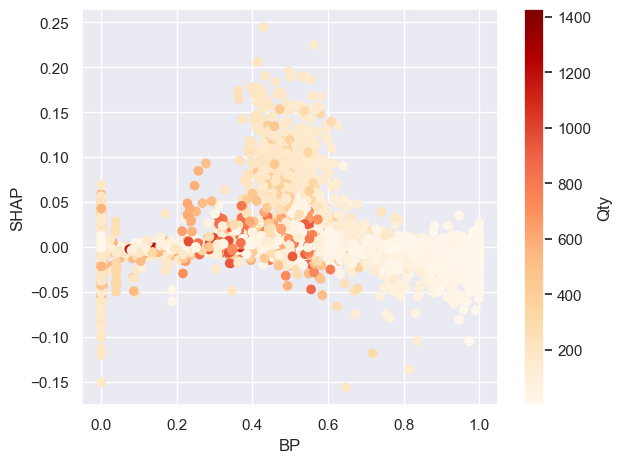

In [70]:
year = ''

# fig, ax = plt.subplots(figsize=(5, 4))
# if year:
#         sns.scatterplot(
#                 data=shap_with_data[shap_with_data.year == year].sample(10000, random_state=42),
#                 # data=shap_with_data.sample(10000, random_state=42),
#                 x='Qty', y='shap_Qty', hue='Tech_Gas', edgecolor=None, alpha=0.3, hue_order=['Fossil Gas', 'Other']
#         )
# else:
#         sns.scatterplot(
#                 data=shap_with_data.sample(10000, random_state=42),
#                 # data=shap_with_data.sample(10000, random_state=42),
#                 x='Qty', y='shap_Qty', hue='BP', edgecolor=None, alpha=0.3
#         )

plot_df = shap_with_data.sample(10000, random_state=42)
scatter = plt.scatter(plot_df['BP'], plot_df['shap_BP'], c=plot_df['Qty'], cmap='OrRd')
plt.colorbar(scatter, label='Qty')
plt.xlabel('BP')
plt.ylabel('SHAP')
# plt.title('2D scatter with color as third variable')
# plt.show()

# if scope == 'BID':
#         # plt.xlim((0.8, 1))
#         plt.ylim((-0.5, 0.5))
# else:
#         # plt.xlim((-1.05, 0.05))
#         plt.ylim((-0.3, 0.4))

# plt.legend(
#         loc='upper center',
#         ncol=2,
#         # frameon=False
# )
# plt.ylabel('SHAP')
# plt.xlabel('Qty [MWh]')
plt.tight_layout()
# plt.savefig(f'../plots/{scope}/explainer/shap_{scope}_dependence_Qty{year}.png', dpi=300)